In [1]:
par_log_transform = True

In [2]:
from pypacmensl.sensitivity.multi_sinks import SensFspSolverMultiSinks
import mpi4py.MPI as mpi
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binom, poisson, norm
from scipy.special import comb     
from math import exp, log, sqrt

from numba import jit

from chebpy import chebfun
import chebpy

from matplotlib.patches import Ellipse
from matplotlib.ticker import FormatStrFormatter
import ipywidgets as widgets

from scipy.stats import logistic
from IPython.display import clear_output

# For nice plots
import seaborn as sns
# sns.set(style='darkgrid')

In [3]:
with np.load('fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('fim_flowcyt.npz', allow_pickle=True) as f:
    flowcyt_prob = f['flowcyt_prob']
    
with np.load('flowcyt_pars.npz') as f:
    kappa=f['kappa']
    sigma_probe=f['sigma_probe']
    mu_bg=f['mu_bg']
    sigma_bg=f['sigma_bg']

with np.load('bursting_parameters.npz') as par:
    k_on = par['kon']
    k_off = par['koff']
    k_r = par['kr']
    gamma = par['gamma']

theta = np.array([k_on, k_off, k_r, gamma])

## Modeling measurement noise with binomial distribution

In [4]:
p_success = 0.5
def BinomialNoiseMatrix(n_max, p_success):
    M = np.zeros((n_max + 1, n_max + 1))  
    for j in range(0, n_max + 1):
            M[:, j] = binom.pmf(np.linspace(0, n_max, n_max+1), j, p_success) 
    return M

n_max = 400
C_binom = BinomialNoiseMatrix(n_max, p_success)

fim_binom = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_binom[itime, :, :] = M
np.savez('fim_binom.npz', fim_binom=fim_binom)

## Modeling combinatorial noise from low image resolution

We consider spot miscounting due to low image resolution. Let $S$ be the size of the cell in terms of the pixels it occupies. Ignore for now the variability in cell sizes. Bright spots may clutter within a pixel, making the image looks like there is only one spot when there should actually be several of them.

Given cell size S and n mRNA molecules, the recorded number of spots is given by the formula
$$
P(Y = j | S, n)
=
\frac
{\binom{S}{j}\binom{n-1}{j-1}}
{\binom{S + n - 1}{n}}
$$

This comes from a combinatoric problem: Given $S$ boxes and $n$ apples, how many ways are there to distribute these apples into these boxes such that there are exactly $j$ non-empty boxes.

In [5]:
num_pixels = 100 # number of pixels occupied by a typical cells
def LowResNoiseMatrix(n_max):
    M = np.zeros((n_max + 1, n_max + 1))  
    M[0,0] = 1.0
    for j in range(1, n_max + 1):
            M[:, j] = comb(num_pixels, np.arange(0, n_max+1))*comb(j-1, np.arange(0,n_max+1)-1)/comb(num_pixels + j - 1, j)       
    return M

n_max = 400
C_lowres = LowResNoiseMatrix(n_max)

fim_lowres = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_lowres[itime, :, :] = M
np.savez('fim_lowres.npz', fim_lowres=fim_lowres)

In [6]:
fim_single_cell = dict()

with np.load('fim_exact.npz') as data:
    fim_single_cell['exact'] = data['fim_exact']

with np.load('fim_binom.npz') as data:
    fim_single_cell['binom'] = data['fim_binom']
    
with np.load('fim_lowres.npz') as data:
    fim_single_cell['lowres'] = data['fim_lowres']  
    
with np.load('fim_composite.npz') as data:
    fim_single_cell['composite'] = data['fim_composite']      

# with np.load('fim_flowcyt_mc_0.npz') as data:
#     fim_flowcyt = data['fim_flowcyt']    

with np.load('fim_flowcyt.npz') as data:
    fim_single_cell['flowcyt'] = data['fim_flowcyt']

if par_log_transform:
    for fim in fim_single_cell.values():
        for it in range(0, len(t_meas)):
            for i in range(0,4):
                for j in range(0,4):
                    fim[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)

In [7]:
def plot_conf_ellipse(fim, num_sigma, ax, par_idx, color='red', label='my_ellipse'):
    covmat = np.linalg.inv(fim)
    [eigvals, eigvecs] = np.linalg.eig(covmat[np.ix_([par_idx[0],par_idx[1]], [par_idx[0],par_idx[1]])])
    
    indx = np.argsort(eigvals)
    indx = np.flip(indx)
    eigvals = eigvals[indx]
    eigvecs = eigvecs[:,indx]
            
    mu0 = np.log10(theta[par_idx[0]])
    mu1 = np.log10(theta[par_idx[1]])
    sigma0 = np.sqrt(eigvals[0])
    sigma1 = np.sqrt(eigvals[1])
    a = num_sigma*sigma0
    b = num_sigma*sigma1

    ax.axvline(mu0, color='k', linestyle='-', alpha=0.1)
    ax.axhline(mu1, color='k', linestyle='-', alpha=0.1)
    
    phi = np.arctan2(eigvecs[1,0],eigvecs[0,0])
    if phi < 0:
        phi = phi + 2*np.pi 

    rot_matrix = np.array([
                            [np.cos(phi), -np.sin(phi)],
                            [np.sin(phi), np.cos(phi)]
                           ])
    
    phi_grid = np.linspace(0, 2*np.pi, 100)
    ellipse_x_r = a*np.cos(phi_grid)
    ellipse_y_r = b*np.sin(phi_grid)
    
    r_ellipse = np.array(rot_matrix@[ellipse_x_r, ellipse_y_r])
    
    ax.plot(r_ellipse[0,:] + mu0, r_ellipse[1,:] + mu1, color=color, label=label)
        
    # Plot the major ax           
    ax.plot([mu0 - eigvecs[0,0]*a, mu0 + eigvecs[0,0]*a], [mu1 - eigvecs[1,0]*a, mu1 + eigvecs[1,0]*a], color=color, 
            linestyle='--')
    
    return 0

def plot_barcodes(fim_mats, labels, colors, ax):                            
    # The uncertainties in eigendirections of different experiments
    for i in range(0, len(fim_mats)):
        
        [eigval, eigvec] = np.linalg.eig(fim_mats[i])
        uncertainties = 1/np.sqrt(eigval)

        ax.hlines(uncertainties, xmin = (2*i + 1)-0.75, xmax = (2*i + 1) + 0.75, color=colors[i], linewidth=2)
        
    ax.set_yscale('log')
    ax.set_xticks(2*np.arange(0, len(fim_mats)) + 1)    
    ax.set_xticklabels(labels)
    ax.set_ylabel('Uncertainty')    
    
    return 0 

In [8]:
ncells_smfish = 1000
ncells_flowcyt = 10000
nfish_mix = 500
nflow_mix = 5000
fim_mix = np.zeros((len(t_meas), 4, 4))

for it in range(0, len(t_meas)):
    fim_mix[it,:,:] = nfish_mix*fim_single_cell['lowres'][it] + nflow_mix*fim_single_cell['flowcyt'][it]      

fim_multi_cells = dict()
fim_multi_cells['mix'] = fim_mix 

for meas_type in fim_single_cell.keys():    
    fim_multi_cells[meas_type] = ncells_smfish*fim_single_cell[meas_type]
fim_multi_cells['flowcyt'] = ncells_flowcyt*fim_single_cell['flowcyt']
 
def compute_combined_fim(fim_array, dt, num_times):
    t_idx = dt*np.linspace(1, num_times, num_times, dtype=int)
    fim = fim_array[t_idx[0], :, :]
    for i in range(1, len(t_idx)):
        fim += fim_array[t_idx[i], :, :]
    return fim

num_times = 5
dt_min = 1
dt_max = int(np.floor(t_meas[-1]/num_times))
dt_array = np.linspace(dt_min, dt_max, dt_max - dt_min +1, dtype=int)

fim_multi_cells_times = dict()
det_fim_multi_cells_times = dict()

for meas_type in fim_multi_cells.keys():
    combined_fim = np.zeros((len(dt_array), 4, 4))
    det_comb_fim = np.zeros((len(dt_array),))
    
    for i in range(0, len(dt_array)):
        combined_fim[i, :, :] = compute_combined_fim(fim_multi_cells[meas_type], dt_array[i],  num_times)           
        det_comb_fim[i] = np.linalg.det(combined_fim[i,:,:])
        
    fim_multi_cells_times[meas_type] = combined_fim 
    det_fim_multi_cells_times[meas_type] = det_comb_fim 

In [9]:
opt_rates = dict()
for meas in fim_multi_cells_times.keys():
    opt_rates[meas] = np.argmax(det_fim_multi_cells_times[meas])

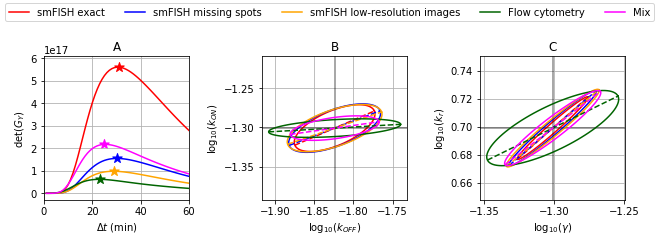

In [10]:
labels = {
        'exact': f'smFISH exact',
        'binom': f'smFISH missing spots',
        'lowres': f'smFISH low-resolution images',
        'flowcyt': f'Flow cytometry',
        'composite': f'smFISH low-resolution images with missing spots',
        'mix': f'Mix',
}

colors = {
        'exact': f'red',
        'binom': f'blue',
        'lowres': f'orange',
        'flowcyt': f'darkgreen',
        'mix': f'magenta',
        'composite': f'k',
}
    
fig, axs = plt.subplots(1,3)
fig.set_size_inches(9, 3)
fig.set_tight_layout(True)
for meas in ['exact', 'binom', 'lowres', 'flowcyt', 'mix']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    
    axs[0].plot(dt_array, dets, label=labels[meas], color=colors[meas])
    axs[0].scatter(dt_array[idx_opt], dets[idx_opt],
               100,
               color=colors[meas], marker='*')
    plot_conf_ellipse(fims[idx_opt], 3, 
                      axs[1], [1,0], colors[meas], '')
    plot_conf_ellipse(fims[idx_opt], 3, axs[2], [3,2], colors[meas], '')

h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower left', ncol=5)
axs[0].set_xlim([0, 60])
axs[0].set_xlabel('$\Delta t$ (min)')
axs[0].set_ylabel('$\operatorname{det}(G_Y)$')

for j in range(1, 3):
    axs[j].set_aspect('equal', 'datalim')
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')    
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')    
axs[2].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs):
    ax.grid()

axs[0].set_title('A')
axs[1].set_title('B')
axs[2].set_title('C')

fig.savefig('fim_dopt.pdf', bbox_inches='tight')

In [11]:
def intensitycondprob(y, x):
    return np.exp(-((y - x*kappa - mu_bg)**2.0)/(2.0*(x*x*sigma_probe**2.0+sigma_bg**2.0)))/ \
    np.sqrt(2*np.pi*(x*x*sigma_probe**2.0+sigma_bg**2.0))

yrange = [mu_bg - 3*sigma_bg, kappa*200 + 3*sigma_bg]
yeval = np.linspace(yrange[0], yrange[1], 1000)

C_flowcyt = np.zeros((1000, 200))
for j in range(0, 200):
    C_flowcyt[:, j] = intensitycondprob(yeval, j)


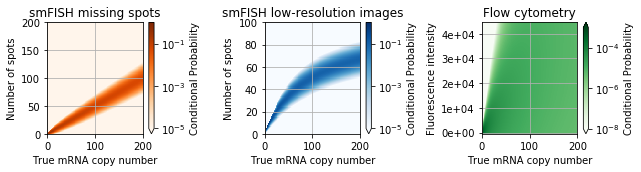

In [12]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(9, 2.5)
fig.set_tight_layout(True)

import matplotlib.colors as colors

C_binom[C_binom<=0.0] = 1.0e-16
p0 = axs[0].pcolormesh(C_binom[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
                         cmap=plt.cm.get_cmap("Oranges"))
fig.colorbar(p0, ax=axs[0], orientation='vertical', extend='min', label=r"Conditional Probability")

C_lowres[C_lowres == 0.0] = 1.0e-16
p1 = axs[1].pcolormesh(C_lowres[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
                         cmap=plt.cm.get_cmap("Blues"))
axs[1].set_ylim([0, 100])
fig.colorbar(p1, ax=axs[1], orientation='vertical', extend='min', label="Conditional Probability")

p2 = axs[2].pcolormesh(np.arange(0, 201), yeval, C_flowcyt, norm=colors.LogNorm(vmin=1.0E-8, vmax=1.0E-3),
                         cmap=plt.cm.get_cmap("Greens"))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
cbar2 = fig.colorbar(p2, ax=axs[2], orientation='vertical', extend='both', label=r"Conditional Probability")


for j in range(0,3):
    axs[j].set_xlabel('True mRNA copy number')
    axs[j].set_ylabel('Number of spots')
axs[2].set_ylabel('Fluorescence intensity')    

models = ['smFISH missing spots', 'smFISH low-resolution images', 'Flow cytometry']
for j in range(0,3):
    axs[j].set_title(models[j])
    axs[j].grid()

fig.savefig('kernel_maps.pdf', bbox_inches='tight')

In [13]:
time_slider = widgets.IntSlider(value=0, min=0, max=len(t_meas)-1, step=1, description='Time:')

def plot_rna_dist_sens(itime):
    fig_smfish = plt.figure()
    fig_smfish.set_tight_layout(True)    
    xmax = len(rna_distributions[itime])-1
    p_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]    
    p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    
    fig_smfish.suptitle(f't = {t_meas[itime]:.2f}')
    ax0 = fig_smfish.add_subplot(1,1,1)
    ax0.plot(np.arange(0, xmax+1), rna_distributions[itime], label='True', linewidth=4)
    ax0.plot(np.arange(0, xmax+1), p_binom, color='orange', linestyle=':', label='Lossy')
    ax0.plot(np.arange(0, xmax+1), p_lowres, color='magenta', linestyle='dotted', label='Low-resolution')
    
    ax0.set_xlabel('RNA molecule count')
    ax0.set_ylabel('Probability')    
    
    ax1 = ax0.twinx()    
    ax1.plot(flowcyt_prob[itime]['yeval']/kappa, flowcyt_prob[itime]['peval'], 
            color='green', linestyle='-', label='Flow cytometry')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_ylabel('Probability density', color='green')    
    fig_smfish.legend(bbox_to_anchor=(0.25, 0, 1, 1), loc = 'lower right')
    fig_smfish.savefig('distributions.pdf', bbox_inches='tight')

widgets.interactive(plot_rna_dist_sens, itime=time_slider)

interactive(children=(IntSlider(value=0, description='Time:', max=400), Output()), _dom_classes=('widget-inter…

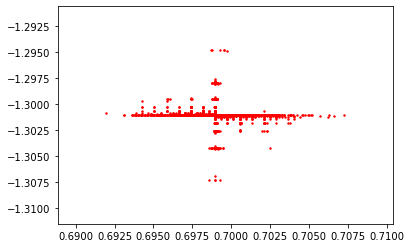

In [18]:
with np.load('ge_mle_correct_fits.npz') as file:
    fits_correct = file['thetas']
with np.load('ge_mle_misfits.npz') as file:
    fits_incorrect = file['thetas']

fig, ax = plt.subplots(1,1)
ax.scatter(fits_correct[:,2], fits_correct[:,3], 2, 'red')
# ax.scatter(fits_correct[:,2], fits_incorrect[:,3], 2, 'orange')